In [1]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
from src.data.dataset_line_rider import DatasetLineRider
from src.model.line_rider import LineRider
from src.trainer.trainer_line_rider import get_median_diff
from src.utils.normalize_baselines import normalize_baselines, compute_start_and_angle
from src.utils.distances import d2
from src.model.line_rider import LineRider
import torch
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def get_patch(patches, n):
    img_patch = patches[n]

    img_out = img_patch[0].permute(1,2,0).cpu().numpy()
    inp = img_out
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)# * 255
    
    inp = cv2.resize(inp, (inp.shape[0]*2, inp.shape[1]))
    cv2.line(inp, (0, int(inp.shape[1]/4)), (inp.shape[0]*2, int(inp.shape[1]/4)), (1, 0, 0), 1)
    #out = np.asarray(inp_with_line)
    out = inp
    
    return out

In [3]:
parameters = {"input_folder": '..\\data\\cBAD-ICDAR2019', "max_side": 1000}
shuffle = {'train': False, 'eval': False}
batch_size_dict = {'train': 1, 'eval': 1}

image_datasets = {inf_type: DatasetLineRider(inf_type=inf_type,
                                            parameters=parameters)
                  for inf_type in ['train', 'eval']}

dataloaders = {inf_type: torch.utils.data.DataLoader(image_datasets[inf_type],
                                                     batch_size=batch_size_dict[inf_type],
                                                     shuffle=shuffle[inf_type],
                                                     num_workers=4)
               for inf_type in ['train', 'eval']}

In [4]:
#model = LineRider(device='cpu')
model = torch.load(os.path.join('..', 'trained_models', 'line_rider', 'line_rider_default.pt'), map_location=torch.device('cpu'))
model.device = torch.device('cpu')
model.data_augmentation = False

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'src.model.line_rider.LineRider' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
#k = 674
k = 4

#batch = next(iter(dataloaders['train']))
image = image_datasets['eval'][k]['image'].unsqueeze(0)#batch['image']
baselines = image_datasets['eval'][k]['baselines']#batch['baselines'][0]
bl_lengths = image_datasets['eval'][k]['bl_lengths']#batch['bl_lengths'][0]

# Compute the number of baselines. The baselines are padded with [-1] and [-1,-1].
# number_of_baselines is the real number of baselines not counting the padding and bl_lengths[idx]
# is the real (not counting the padding) length of baseline idx.
number_of_baselines = min([idx for idx in range(0, len(bl_lengths)) if bl_lengths[idx] == -1])

start_points = torch.tensor([[bl[0, 0], bl[0, 1]] for bl in baselines[0:number_of_baselines]])
box_size = min(64, get_median_diff(start_points))
box_size = 96


#plt.figure(figsize = (10,10))
#plt.imshow(image[0].permute(1,2,0).numpy())

In [6]:
n = 10

box_size=32

# Normalise the baselines such that each line segment has the length 'box_size'
bl = baselines[n][:bl_lengths[n]]
bl_n = normalize_baselines(bl, box_size)
bl_n = bl_n
bl_n_end_length = d2(bl_n[-1, 0], bl_n[-1, 1], bl_n[-2, 0], bl_n[-2,1])/box_size


c_list, bl_end_list, bl_end_length_list, patches = model(img=image, box_size=box_size, baseline=bl_n, reset_idx=100)

print('Number of patches = ' + str(len(patches)))

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\nn\functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


AttributeError: 'LineRider' object has no attribute 'model_line'

In [172]:
#bl_end_list

In [173]:
#bl_end_length_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


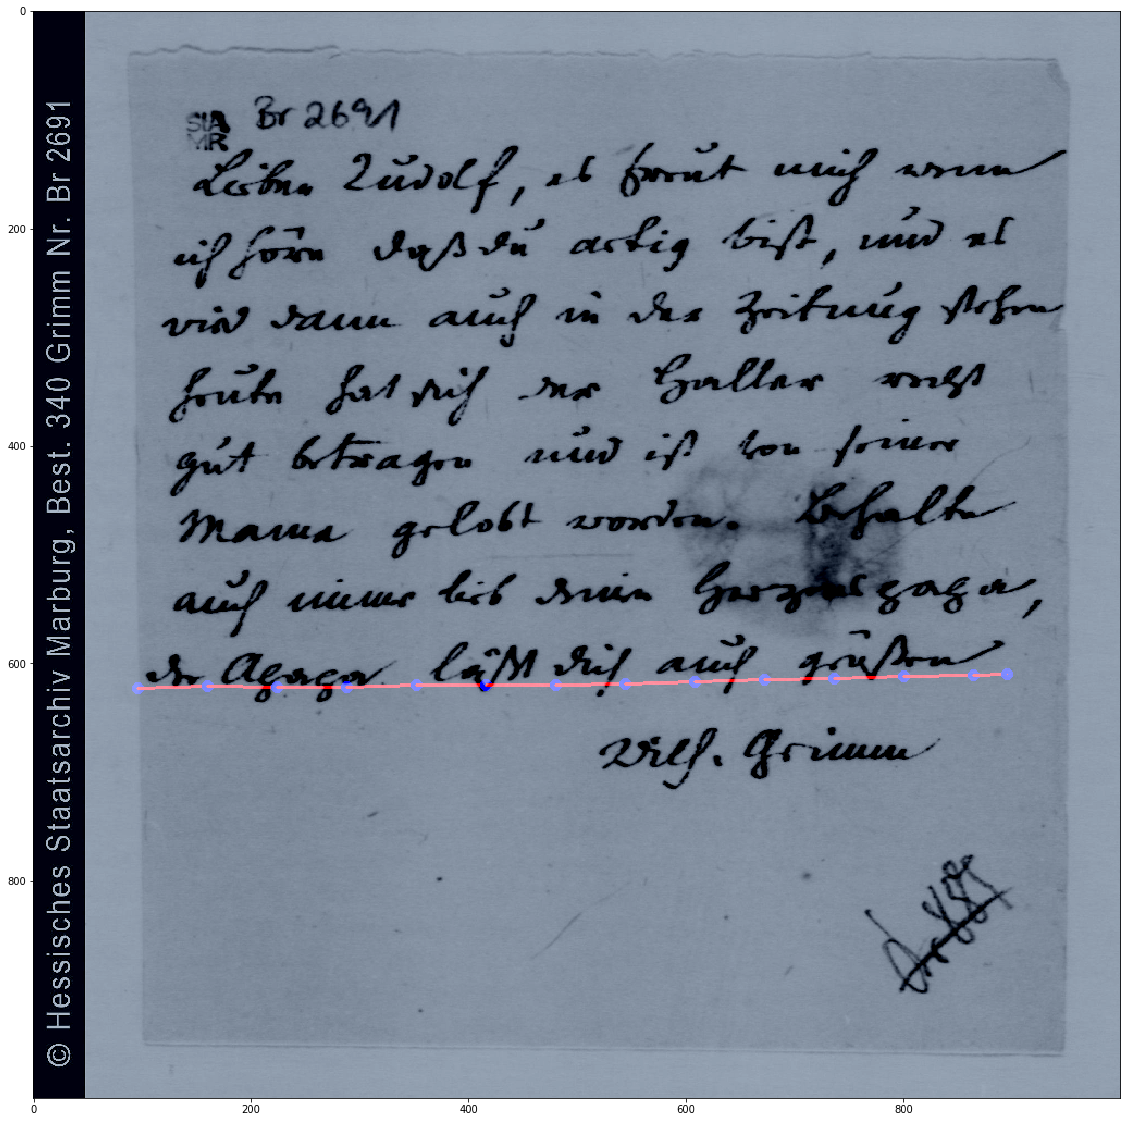

In [174]:
end_k = torch.argmax(bl_end_list)-1

baselines_n = c_list.unsqueeze(0)

#img_cv2 = cv2.imread('colors.jpg')#
img_cv1 = image[0].permute(1,2,0).numpy()
img_cv2 = np.zeros((1000,1000,3), dtype=np.float32)

for N, bl in enumerate(baselines_n):
    for k, p in enumerate(bl):
        if k == 0:
            p_list = p#.get_as_list()
            coords = (int(p_list[0]), int(p_list[1]))
            c_last = coords
            
            cv2.circle(img_cv2, coords, 3, (0,0,255), thickness=3)
            continue
        else:
            p_list = p#.get_as_list()
            coords = (int(p_list[0]), int(p_list[1]))
            if N == n:
                cv2.line(img_cv2, c_last, coords, (0,255,0), thickness=2)
            else:
                if k == end_k or bl_end_list[k] > 0.7:
                    x = (coords[0]-c_last[0])*bl_end_length_list[k] + c_last[0]
                    y = (coords[1]-c_last[1])*bl_end_length_list[k] + c_last[1]
                    coords = (x, y)
                cv2.line(img_cv2, c_last, coords, (255,0,0), thickness=2)
                
            cv2.circle(img_cv2, coords, 3, (0,0,255), thickness=3)
            c_last = coords
        if k == end_k or bl_end_list[k] > 0.7:
            break
            
            
comb = cv2.addWeighted(img_cv2,1.0,img_cv1,0.3,0)
plt.figure(figsize = (20,20))
plt.imshow(comb)

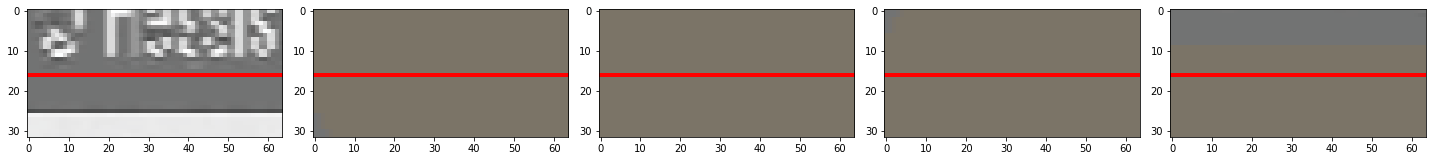

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=min(5, len(patches)), figsize=(20, 20))
for i in range(0,min(5, len(patches))):
    axes[i].imshow(get_patch(patches, i))
fig.tight_layout()

In [228]:
import torchvision

def draw_baselines(image: torch.tensor, baselines: torch.tensor, idx=-1):
    """
    Creates a visualization of the model output. It draws points every baseline point and connects them with lines.
    Returns the resulting image as a torch tensor.
    :param image: The input image, assumes that is is normalized with imageNet parameters.
    :param baselines: The predicted baselines as a torch tensor
    :param idx: (optional) if set to a specific index, colors this baseline in a different color
    :return: The resulting image
    """
    h = image.shape[1]
    w = image.shape[2]

    img_cv1 = image.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_cv1 = std * img_cv1 + mean
    img_cv1 = np.clip(img_cv1, 0, 1)

    img_cv2 = np.zeros((h, w, 3), dtype=np.float32)

    baselines_n = baselines

    for N, bl in enumerate(baselines_n):
        for k, p in enumerate(bl):
            if k == 0:
                coords = (int(p[0]), int(p[1]))
                c_last = coords

                cv2.circle(img_cv2, coords, 3, (0, 0, 1.0), thickness=3)
                continue
            else:
                coords = (int(p[0]), int(p[1]))
                if N == idx:
                    cv2.line(img_cv2, c_last, coords, (0, 1.0, 0), thickness=2)
                else:
                    cv2.line(img_cv2, c_last, coords, (1.0, 0, 0), thickness=2)

                cv2.circle(img_cv2, coords, 3, (0, 0, 1.0), thickness=3)
                c_last = coords

    img_cv2 = img_cv2.astype(np.float64)
    comb = cv2.addWeighted(img_cv2, 0.7, img_cv1, 0.3, 0)
    # comb = cv2.cvtColor(comb, cv2.COLOR_BGR2RGB)
    comb = torchvision.transforms.ToTensor()(comb).float()

    return comb

In [229]:
do = draw_baselines(image[0], c_list.unsqueeze(0))

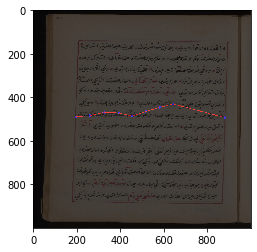

In [230]:
plt.imshow(do.permute(1,2,0).numpy())

In [286]:
def compute_start_and_angle(baseline, idx, data_augmentation=False, box_size=None):
    """
    For a given baseline returns the point at index=idx and the angle the baseline segment [idx, idx+1] has
    towards a horizontal line.
    NOTE: The angle gets a negative sign compared to the mathematical positive direction because
    the positive y direction is downwards.
    :param baseline: The baseline as a torch.tensor
    :param idx: The index
    :param data_augmentation: if set to True perturbs the point and angle randomly by small values
    :return: a tuple of x coordinate of the point, y coordinate and the angle
    """
    if torch.abs(baseline[idx, 0] - baseline[idx + 1, 0]) < 0.001:
        if baseline[idx, 1] > baseline[idx + 1, 1]:
            angle = torch.tensor(math.pi / 2.0)
        else:
            angle = torch.tensor(-math.pi / 2.0)
    else:
        if baseline[idx, 0] < baseline[idx + 1, 0]:
            angle = torch.atan((baseline[idx + 1, 1] - baseline[idx, 1]) / (baseline[idx, 0] - baseline[idx + 1, 0]))
        else:
            if torch.abs(baseline[idx, 1] - baseline[idx + 1, 1]) < 0.001:
                angle = torch.tensor(math.pi / 2)
            else:
                if baseline[idx, 1] > baseline[idx + 1, 1]:
                    angle = torch.atan(
                        (baseline[idx, 0] - baseline[idx + 1, 0]) / (baseline[idx, 1] - baseline[idx + 1, 1])) + math.pi/2
                else:
                    angle = torch.atan(
                        (baseline[idx, 0] - baseline[idx + 1, 0]) / (baseline[idx, 1] - baseline[idx + 1, 1])) - math.pi/2
    # ^ positive x direction is towards right and positive y direction is downwards.

    x = baseline[idx, 0]
    y = baseline[idx, 1]

    # Perturb position and angle, otherwise the network will learn to always predict angle = 0
    if data_augmentation:
        print('data_augmentation')
        if box_size is not None:
            x += random.randint(-box_size/4, box_size/4)
            y += random.randint(-box_size/4, box_size/4)
        else:
            x += random.randint(-5, 5)
            y += random.randint(-10, 10)
        angle += random.uniform(-0.3, 0.3)

    return x, y, angle

In [287]:
import math

In [288]:
inpt = torch.tensor([[0.0, 0.0], [-1.0, 0.000001]])

x, y, angle = compute_start_and_angle(inpt, 0)
print('x:     ' + str(x.item()))
print('y:     ' + str(y.item()))
print(' ')
print('angle: ' + str(180.0/math.pi*angle.item()))

x:     0.0
y:     0.0
 
angle: 90.00000250447816
